## Test how hard one can infer with the VarEM Alogrithm



In [6]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## simulation to test if we should enforce causal strucutre each time


In [8]:
n = 10000
J = 6
I = 5
f_score_init = []
f_score_each = []
mean_squared_error_init = []
mean_squared_error_each = []
ll_score_init = []
ll_score_each = []
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 1})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "init")  
    
    CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
    f_score_init.append(score)
    singals_estimation_VAR = CausalVarEM_est.Signals[:,best_perm]
    mean_squared_error_init.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_init.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))

    CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "each")
    CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
    f_score_each.append(score)
    singals_estimation_VAR = CausalVarEM_est.Signals[:,best_perm]
    mean_squared_error_each.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_each.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))

df = pd.DataFrame({"f_score_init" : f_score_init, 
                   "f_score_each" : f_score_each, 
                   "mean_squared_error_init" : mean_squared_error_init, 
                   "mean_squared_error_each" : mean_squared_error_each,
                     "ll_score_init" : ll_score_init, 
                     "ll_score_each" : ll_score_each})


100%|██████████| 100/100 [3:04:57<00:00, 110.98s/it]


In [9]:
df.to_csv("causal_var_em.csv")


## Results

In [12]:
df = pd.read_csv("causal_var_em.csv", index_col=0)
print(df.mean())
print(df.std())


f_score_init                   0.328565
f_score_each                   0.255312
mean_squared_error_init        1.241380
mean_squared_error_each        1.174276
ll_score_init             -13120.487585
ll_score_each             -13027.338335
dtype: float64
f_score_init                 0.182035
f_score_each                 0.146522
mean_squared_error_init      0.134086
mean_squared_error_each      0.112627
ll_score_init              499.546642
ll_score_each              507.305755
dtype: float64


## look at one example


In [13]:
data = dgp(prior={"loc" : 0, "scale" : 1}, noise_dict=  {"loc" : 0, "scale" : 1})
n = 10000
J = 6
I = 5
data.generate_data(n=n, J=J, I=I, random_state=0)
CausalVarEM_init = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
CausalVarEM_init.fit(data.data_observed, J = J)
best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_init.A)
singals_estimation_VAR_init = CausalVarEM_init.Signals[:,best_perm]

CausalVarEM_each = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1, mode = "each")
CausalVarEM_each.fit(data.data_observed, J = J)
best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_each.A)
singals_estimation_VAR_each = CausalVarEM_each.Signals[:,best_perm]


Initializing A with true A + noise


Diff: 0.0318: 100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 94019.29it/s]


Initializing A with true A + noise


Diff: 0.0318: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90047.10it/s]


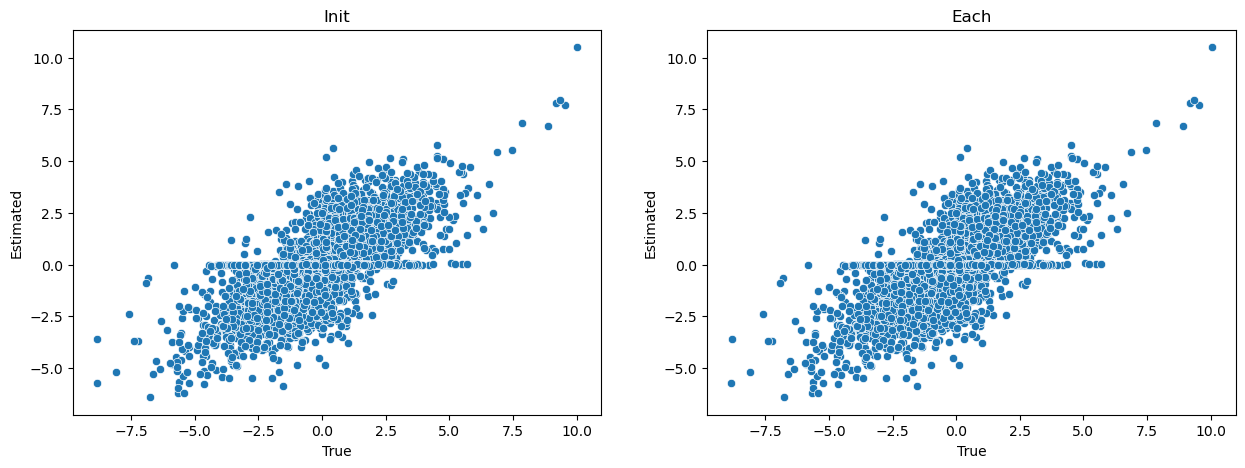

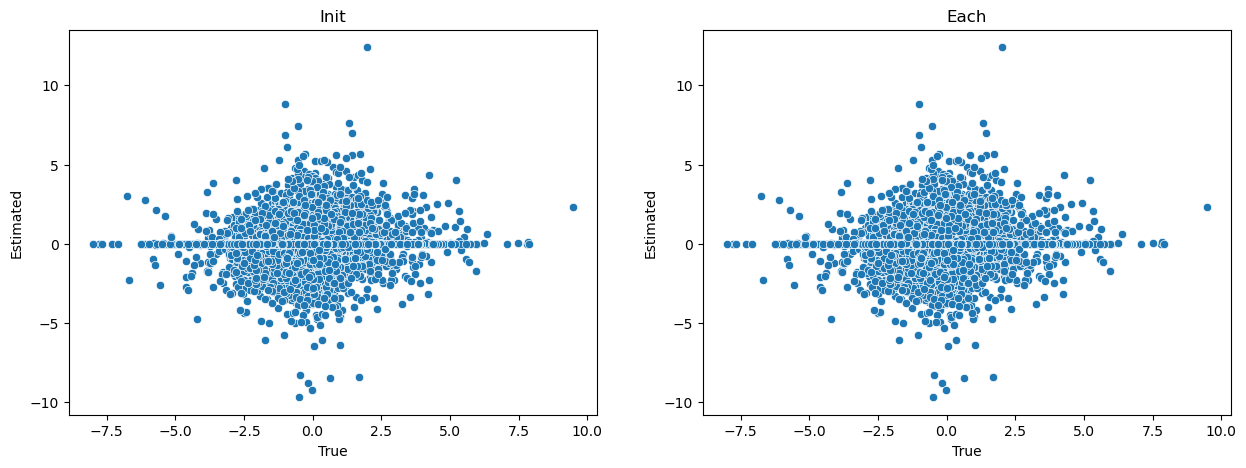

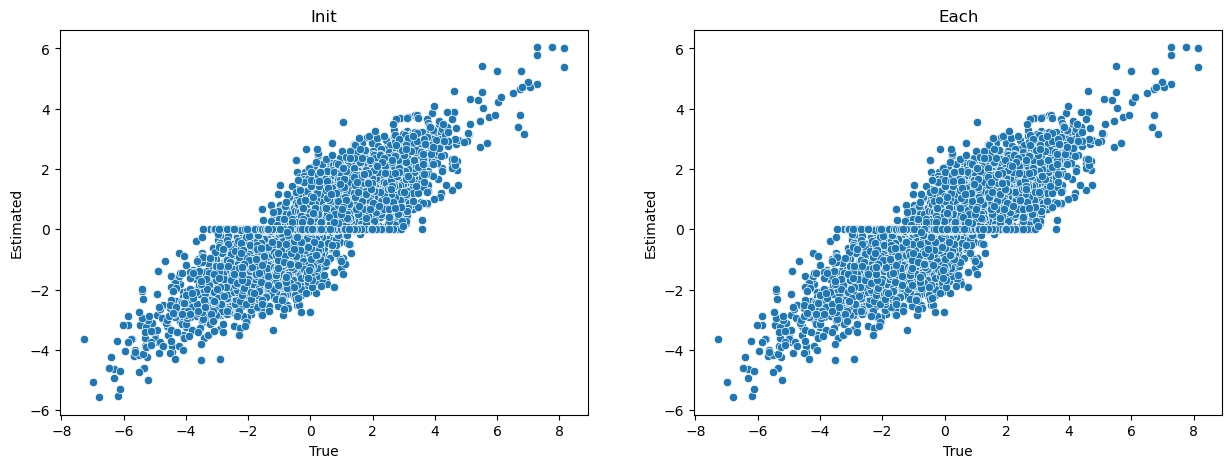

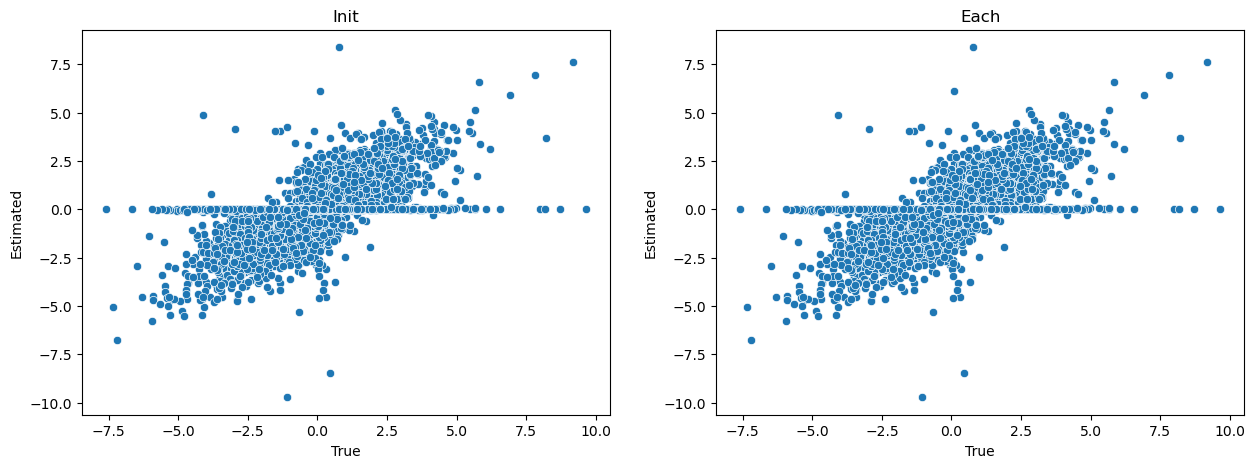

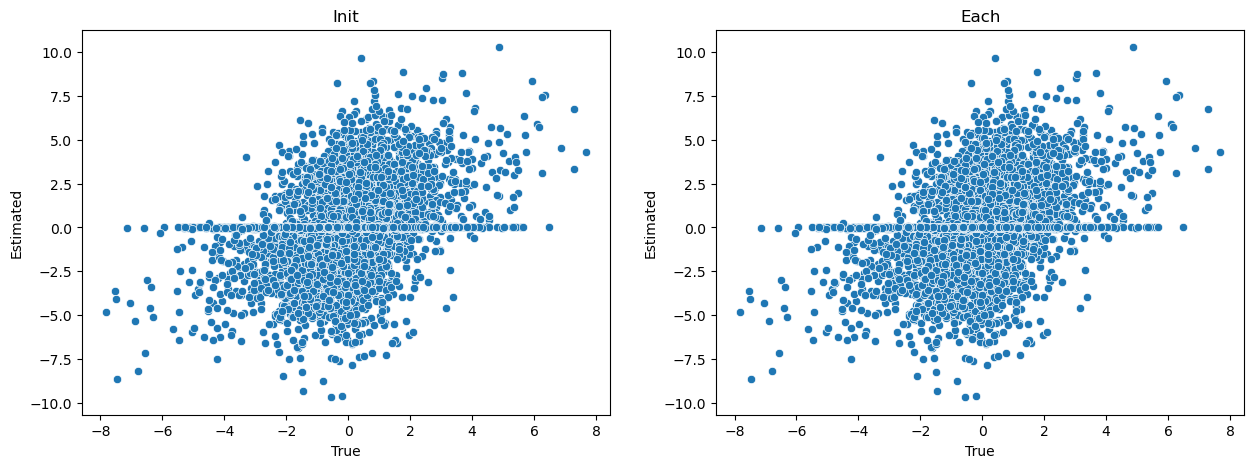

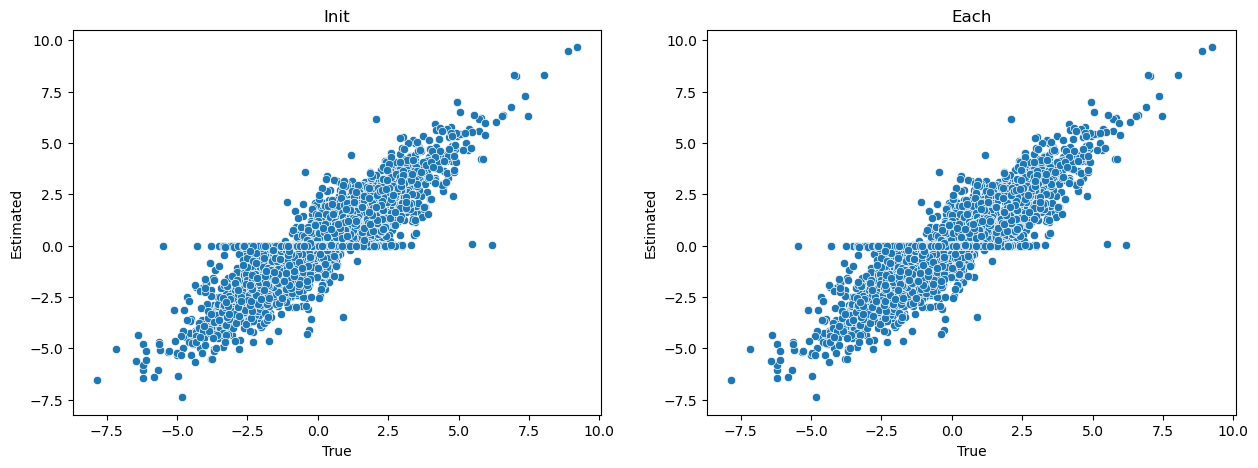

In [14]:
# plot the results
for i in range(J):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(x=data.signals[:,i], y=singals_estimation_VAR_init[:,i], ax=ax[0])
    ax[0].set_title("Init")
    ax[0].set_xlabel("True")
    ax[0].set_ylabel("Estimated")
    sns.scatterplot(x=data.signals[:,i], y=singals_estimation_VAR_each[:,i], ax=ax[1])
    ax[1].set_title("Each")
    ax[1].set_xlabel("True")
    ax[1].set_ylabel("Estimated")
    plt.show()


## look at full results


<Axes: xlabel='ll_score_each', ylabel='Count'>

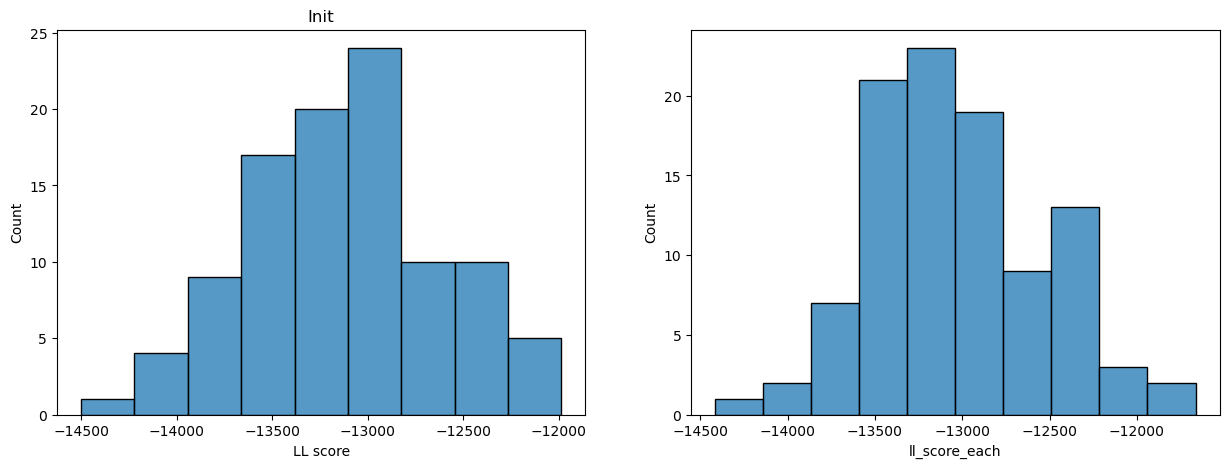

In [15]:
# plot ll score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df["ll_score_init"], ax=ax[0])
ax[0].set_title("Init")
ax[0].set_xlabel("LL score")
sns.histplot(df["ll_score_each"], ax=ax[1])


Text(0.5, 0, 'F score')

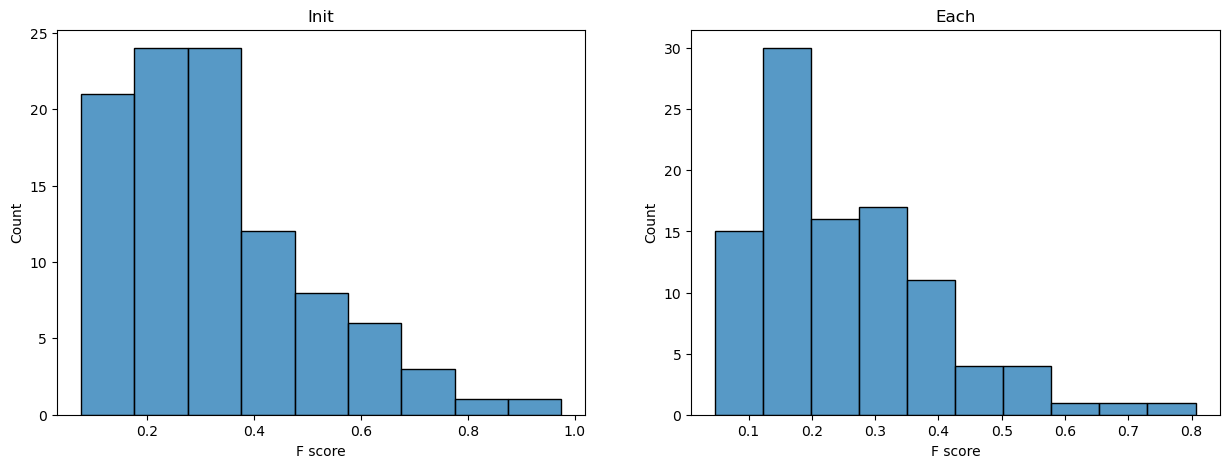

In [16]:
# plot f score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df["f_score_init"], ax=ax[0])
ax[0].set_title("Init")
ax[0].set_xlabel("F score")
sns.histplot(df["f_score_each"], ax=ax[1])
ax[1].set_title("Each")
ax[1].set_xlabel("F score")

Text(0.5, 0, 'MSE')

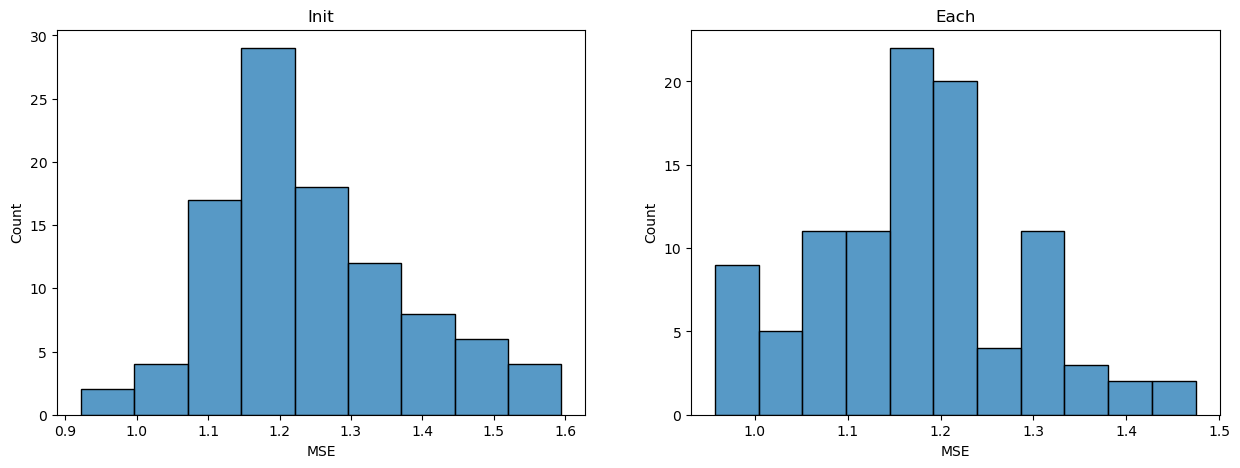

In [17]:
# plot mse
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df["mean_squared_error_init"], ax=ax[0])
ax[0].set_title("Init")
ax[0].set_xlabel("MSE")
sns.histplot(df["mean_squared_error_each"], ax=ax[1])
ax[1].set_title("Each")
ax[1].set_xlabel("MSE")
